In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Override/set credentials in env var
os.environ['CWD'] = str(Path(os.getcwd()).parent)

# Base paths
cwd = Path(os.environ['CWD'])
dir_data = cwd / 'data'
dir_models = cwd / 'models'
dir_models.mkdir(exist_ok=True, parents=True)


import pickle
def picklesave(o, f):
    with open(f, 'wb') as fp:
        pickle.dump(o, fp)
        
def pickleload(f):
    with open(f, 'rb') as fp:
        return pickle.load(fp)


from tqdm import tqdm 
tqdm.pandas()

In [2]:
# !pip install -e ..

# Load data

In [3]:
import pandas as pd

df_tr_ev = pd.read_csv(dir_data / 'train.csv')
df_tr_ev['split'] = 'tr'
df_te = pd.read_csv(dir_data / 'test.csv')
df_te['split'] = 'te'

df = pd.concat([df_tr_ev, df_te])

# Feature Extraction

## Set punctuation features (statistics) from unprocessed texts

In [4]:
from author_classification.feature_extraction import get_text_punctuation_stat_features
df_tr_ev['dict_punct_features'] = df_tr_ev['text'].progress_apply(get_text_punctuation_stat_features)

punctuation_feature_names = df_tr_ev['dict_punct_features'].iloc[0].keys()

# Put each punctuation feature in a column in the dataframe
from author_classification.utils import expand_col_dicts
df_tr_ev = expand_col_dicts(df_tr_ev, colname_dict='dict_punct_features')

2022-04-26 11:53:44.422947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 11:53:44.422986: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|███████████████████████████████████| 40000/40000 [00:08<00:00, 4949.82it/s]


## Sentiment and readability from unprocessed texts

In [5]:
from author_classification.feature_extraction import (
    set_text_readability_statistics, set_text_polarity_subjectivity, LIST_TUPLES_READABILITY_STATISTICS
)
df_tr_ev = set_text_readability_statistics(df_tr_ev, colname_text='text')
df_tr_ev = set_text_polarity_subjectivity(df_tr_ev, colname_text='text')

df_measures_per_author = df_tr_ev.groupby('author').agg(
    {
        **{'polarity': list, 'subjectivity': list},
        **{k:list for k in list(zip(*LIST_TUPLES_READABILITY_STATISTICS))[0]}
    }
)

100%|███████████████████████████████████| 40000/40000 [00:17<00:00, 2338.66it/s]


## Preprocess texts

In [6]:
# Preprocess text
from author_classification.preprocessing import preprocess_text
# We should also make another column
df_tr_ev['text_processed'] = df_tr_ev['text'].progress_apply(lambda txt: preprocess_text(txt, lemmatize=True))

100%|████████████████████████████████████| 40000/40000 [03:51<00:00, 172.54it/s]


## n-grams

### Split dataset now to avoid data leakage in tfidf and tsvd

In [7]:
from sklearn.model_selection import train_test_split
df_tr, df_ev = train_test_split(df_tr_ev, test_size=0.15, stratify=df_tr_ev['author'], random_state=288)

### Char-level tfidf on unprocessed texts
Capture fine-grain char-level features

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_char = TfidfVectorizer(
    ngram_range=(1,5),
    analyzer='char',
    min_df=40,
    max_df=0.7
)

X_tfidf_char_tr = tfidf_char.fit_transform(df_tr['text']).astype(np.float32)
print(f'{len(tfidf_char.vocabulary_)} features')
X_tfidf_char_ev = tfidf_char.transform(df_ev['text']).astype(np.float32)

picklesave(tfidf_char, dir_models / 'tfidf_char.pkl')

61903 features


### Reduce dimensionality with TSVD

In [9]:
from sklearn.decomposition import TruncatedSVD

tsvd_char = TruncatedSVD(n_components=1000, random_state=288)
X_tfidf_char_tsvd_tr = tsvd_char.fit_transform(X_tfidf_char_tr)
print(f'Cumulative sum of explained variance ratio kept by tsvd_char: {round(tsvd_char.explained_variance_ratio_.cumsum()[-1], 4)}')
X_tfidf_char_tsvd_ev = tsvd_char.transform(X_tfidf_char_ev)

picklesave(tsvd_char, dir_models / 'tsvd_char.pkl')

Cumulative sum of explained variance ratio kept by tsvd_char: 0.4212000072002411


### Word-level tfidf on processed texts
Capture coarse-grained word-level features, relations between words, etc.

#### Fit word-level tfidf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word = TfidfVectorizer(
    ngram_range=(1,2),
    analyzer='word',
    min_df=5,
    max_df=0.7
)

X_tfidf_word_tr = tfidf_word.fit_transform(df_tr['text_processed']).astype(np.float32)
print(f'{len(tfidf_word.vocabulary_)} features')
X_tfidf_word_ev = tfidf_word.transform(df_ev['text_processed']).astype(np.float32)

picklesave(tfidf_word, dir_models / 'tfidf_word.pkl')

29243 features


### Reduce dimensionality with TSVD

In [11]:
from sklearn.decomposition import TruncatedSVD
tsvd_word = TruncatedSVD(n_components=1500, random_state=288)
X_tfidf_word_tsvd_tr = tsvd_word.fit_transform(X_tfidf_word_tr)
print(f'Cumulative sum of explained variance ratio kept by tsvd_word: {round(tsvd_word.explained_variance_ratio_.cumsum()[-1], 4)}')
X_tfidf_word_tsvd_ev = tsvd_word.transform(X_tfidf_word_ev)

picklesave(tsvd_word, dir_models / 'tsvd_word.pkl')

Cumulative sum of explained variance ratio kept by tsvd_word: 0.44040000438690186


# Preparing data to train + eval

## Get punctuation, sentiment and readability feature vectors for each sample

In [12]:
from author_classification.feature_extraction import get_feature_matrix_from_dataframe_with_feature_columns

X_tr_stats = get_feature_matrix_from_dataframe_with_feature_columns(df_tr)
X_ev_stats = get_feature_matrix_from_dataframe_with_feature_columns(df_ev)

### Scale these punctuation, sentiment and readability features as they are independent of each other (we are not interested in the angle defined by these)

In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_tr_stats_scaled = scaler.fit_transform(X_tr_stats)
X_ev_stats_scaled = scaler.transform(X_ev_stats)

## Extract sentence vectors with pretrained model for Sentence Similarity
This is to also help the model capture the semantic features of the passages

In [14]:
from sentence_transformers import SentenceTransformer
model_sent_embs = SentenceTransformer('all-MiniLM-L6-v2')
X_sentembs_tr = model_sent_embs.encode(df_tr['text'].values, show_progress_bar=True)
X_sentembs_ev = model_sent_embs.encode(df_ev['text'].values, show_progress_bar=True)

Batches:   0%|          | 0/1063 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

## Concatenate all features
Concatenated features consist of:
- Character features
- Word features
- Punctuation, sentiment and readability features
- Semantic embeddings

In [15]:
X_tr = np.hstack([X_tr_stats_scaled, X_tfidf_char_tsvd_tr, X_tfidf_word_tsvd_tr, X_sentembs_tr])
X_ev = np.hstack([X_ev_stats_scaled, X_tfidf_char_tsvd_ev, X_tfidf_word_tsvd_ev, X_sentembs_ev])

## Preprocess labels for keras

In [16]:
from sklearn.preprocessing import OneHotEncoder
le = OneHotEncoder()
Y_tr = le.fit_transform(df_tr['author'].values.reshape(-1,1))
Y_ev = le.transform(df_ev['author'].values.reshape(-1,1))
# Save label encoder too to use it when inferring
picklesave(le, dir_models / 'le.pkl')

# Training the model

## Get model

In [17]:
from author_classification.modeling import get_model
clf = get_model(input_shape=X_tr.shape[1], n_classes=Y_tr.shape[1])
clf.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2920)]            0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 2920)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                93472     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 32)                0     

2022-04-26 12:18:30.614323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-26 12:18:30.615372: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 12:18:30.615404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (16c147a04f9e): /proc/driver/nvidia/version does not exist
2022-04-26 12:18:30.615677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fit model

In [18]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
callbacks = []
callbacks.append(EarlyStopping(monitor='val_categorical_accuracy', patience=50, verbose=0, mode='max'))
callbacks.append(ModelCheckpoint(dir_models / 'clf.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max', save_weights_only=False))

     
clf.fit(
    x=X_tr,
    y=Y_tr.todense(),
    batch_size=64,
    epochs=1000,
    validation_data=(
        X_ev,
        Y_ev.todense()
    ),
    callbacks=callbacks
)

2022-04-26 12:18:31.189472: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397120000 exceeds 10% of free system memory.
2022-04-26 12:18:31.492017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-26 12:18:31.495587: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2592005000 Hz


Epoch 1/1000
532/532 [==============================] - 3s 4ms/step - loss: 0.5097 - categorical_accuracy: 0.8142 - val_loss: 0.2523 - val_categorical_accuracy: 0.9127
Epoch 2/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2906 - categorical_accuracy: 0.9006 - val_loss: 0.2196 - val_categorical_accuracy: 0.9222
Epoch 3/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2542 - categorical_accuracy: 0.9120 - val_loss: 0.2149 - val_categorical_accuracy: 0.9223
Epoch 4/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2544 - categorical_accuracy: 0.9129 - val_loss: 0.2140 - val_categorical_accuracy: 0.9225
Epoch 5/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2523 - categorical_accuracy: 0.9131 - val_loss: 0.2139 - val_categorical_accuracy: 0.9235
Epoch 6/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2523 - categorical_accuracy: 0.9127 - val_loss: 0.2138 - val_categorical_accuracy:

532/532 [==============================] - 2s 4ms/step - loss: 0.2472 - categorical_accuracy: 0.9165 - val_loss: 0.2127 - val_categorical_accuracy: 0.9233
Epoch 50/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2458 - categorical_accuracy: 0.9172 - val_loss: 0.2127 - val_categorical_accuracy: 0.9233
Epoch 51/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2484 - categorical_accuracy: 0.9157 - val_loss: 0.2127 - val_categorical_accuracy: 0.9233
Epoch 52/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2490 - categorical_accuracy: 0.9145 - val_loss: 0.2127 - val_categorical_accuracy: 0.9233
Epoch 53/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2515 - categorical_accuracy: 0.9125 - val_loss: 0.2126 - val_categorical_accuracy: 0.9233
Epoch 54/1000
532/532 [==============================] - 2s 4ms/step - loss: 0.2502 - categorical_accuracy: 0.9154 - val_loss: 0.2126 - val_categorical_accuracy: 0.9233


## Load model at best epoch

In [20]:
from tensorflow.keras.models import load_model
from author_classification.modeling import scale_fn # Needed to load the model

clf_best = load_model(dir_models / 'clf.h5', custom_objects={'scale_fn': scale_fn})

## Predict

In [21]:
from sklearn.metrics import classification_report

Y_hat_tr = le.inverse_transform(clf_best.predict(X_tr))
Y_hat_ev = le.inverse_transform(clf_best.predict(X_ev))

2022-04-26 13:35:00.246768: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 397120000 exceeds 10% of free system memory.
2022-04-26 13:35:01.513112: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 70080000 exceeds 10% of free system memory.


## Evaluate on training data (to see how much overfitted it is)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(df_tr['author'], Y_hat_tr))

              precision    recall  f1-score   support

       defoe       0.97      0.98      0.97      8500
     dickens       0.94      0.92      0.93      8500
       doyle       0.94      0.95      0.94      8500
       twain       0.93      0.94      0.93      8500

    accuracy                           0.95     34000
   macro avg       0.95      0.95      0.95     34000
weighted avg       0.95      0.95      0.95     34000



## Evaluate on eval (dev) data

In [23]:
from sklearn.metrics import classification_report
print(classification_report(df_ev['author'], Y_hat_ev))

              precision    recall  f1-score   support

       defoe       0.95      0.96      0.96      1500
     dickens       0.92      0.89      0.90      1500
       doyle       0.91      0.93      0.92      1500
       twain       0.91      0.92      0.91      1500

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



### Plot confusion matrix (eval data)

Normalized confusion matrix


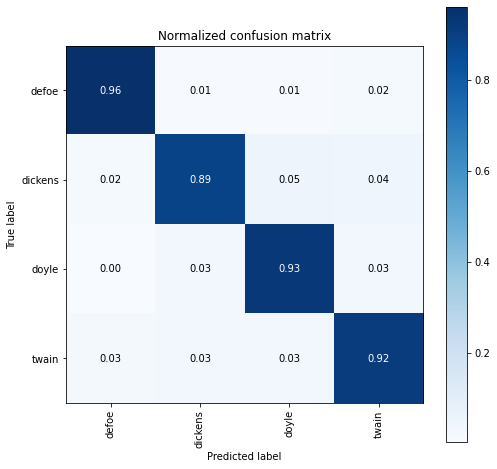

In [24]:
from author_classification.confusion_matrix import plot_cm
plot_cm(df_ev['author'], Y_hat_ev.flatten())

### Show some examples of bad classifications (eval)

In [25]:
df_ev['author_predicted'] = Y_hat_ev

with pd.option_context('display.max_colwidth', None):
    display(df_ev[df_ev['author'] != df_ev['author_predicted']].groupby('author').sample(2, random_state=288)[['text', 'author', 'author_predicted']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,author,author_predicted
index,,,
9626,"\n\nI immediately cut the twisted flags or rushes which they had bound him\nwith, and would have helped him up; but he could not stand or speak,\nbut groaned most piteously, believing, it seems, still, that he was\nonly unbound in order to be killed",defoe,twain
7562,"A young\nman, anxious for other reasons to marry, is sometimes heard to express\nhis conviction that he might live more cheaply married than single. \nThere could be no assertion more inconsistent with all common\nexperience",defoe,doyle
19763,"\nWhenever I take notice of a child in the school, it seems to me as if\nits face swelled INSTANTLY. Just as they do when the text is given out. --Frank, that’s a\nschoolmaster. \n\n‘I cannot recall your name,’ he said, ‘but I remember to have seen you\nin your school",dickens,doyle
17279,"The sheriffs with their great chains\nand nosegays, other civic gewgaws and monsters, criers, ushers, a great\ngallery full of people,—a large theatrical audience,—looked on, as the\ntwo-and-thirty and the Judge were solemnly confronted",dickens,twain
22094,"\n\n“I had gone up to town about an investment, and I met him in Regent\nStreet with hardly a coat to his back or a boot to his foot. \n\n“‘Here we are, Jack,’ says he, touching me on the arm; ‘we’ll be as\ngood as a family to you",doyle,dickens
29003,"Their escort did not halt, however, but pushed on, followed by\na great crowd of Mormons, until they reached a waggon, which was\nconspicuous for its great size and for the gaudiness and smartness of\nits appearance",doyle,twain
33149,"Whitely was\n suddenly thirsty, and begged for water, and drank it slowly, with\n his eyes over the top of the cup, fixed on her large black eyes,\n which gazed on him quite as curiously as he on her",twain,dickens
34773,"There had long been a truce between the opposing\nforces, but according to the Guide-Book, Raynauld of Chatillon, Lord of\nKerak, broke it by plundering a Damascus caravan, and refusing to give up\neither the merchants or their goods when Saladin demanded them",twain,defoe
